# 5a. Setup environment

## Load packages

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler

## Define file paths

### Set input directory

In [12]:
# main dir
wd = "/project/shefflab/processed/gomez_atac/results_pipeline/differential/gitk_univ"

# path of the scATAC figment files
scATAC_dir = os.path.join(wd, "scATAC")
# path of the pseudo-bulk data 
pseudobulk_dir = os.path.join(wd, "pseudobulk_data")
# path of the pseudo-bulk data by predefined cell type clusters
cluster_dir = os.path.join(pseudobulk_dir,"cell_type_cluster")
# cluster barcodes table
cluster_barcode = os.path.join(scATAC_dir,"cluster_barcode_2024-01-29.csv")

# path for reninness score results
reninScore_dir = "/scratch/bx2ur/code/reninness_score/outputs"
# bulkATAC
bulk_res = os.path.join(reninScore_dir,"gitk_univ")
# leave one out 
loo_res = os.path.join(reninScore_dir,"testloo")
# pseudo-bulk: pre-defined cell type clusters
cluster_res = os.path.join(reninScore_dir,"pseudobulk")
# pseudo-bulk: cell barcode
sc_res = os.path.join(reninScore_dir,"singlecell")

# file name for starspace embedding docs
doc_embed = "train_starspace_embed_mm10.txt"
word_embed = "starspace_model_mm10.tsv"


### Set output directory

In [13]:
# path to save the bed files for the pseudo-bulk data by cell barcode
barcode_dir = os.path.join(pseudobulk_dir,"cell_barcodes")

# path to save plots
plot_dir = os.path.join(wd, "plot", "reninness_score")
bar_plt = os.path.join(plot_dir, "bar")
tsne_plt = os.path.join(plot_dir, "tsne")
heatmap_plt = os.path.join(plot_dir, "heatmap")
acc_plt=os.path.join(plot_dir, "acc")

## Define functions

In [4]:
# get the embeddings from raw starspace outputs 

def get_embedding_matrix(path_embeded_document, path_word_embedding, no_labels):
    X, y = get_sample_embedding(path_embeded_document)
    X_label, y_label =  get_label_embedding(path_word_embedding, no_labels)
    
    X.extend(X_label)
    y.extend(y_label)
    
    return X, y


def get_sample_embedding(path_embeded_document):
    # get the embedding for the samples

    # read the raw starspace embeding
    # odd rows are regions+label for each sample
    # even rows are embeddings 
    document_embedding = pd.read_csv(path_embeded_document, header = None, skiprows=4)
    document_embedding = (document_embedding[0].str.split('__label__', expand = True))
    document_embedding[1] = document_embedding[1].shift(1)
    document_embedding = document_embedding.dropna()
    
    X = document_embedding[0].str.split(' ', expand = True)
    X = X[list(X)[0:-1]].astype(float)
    X = list(X.values)
    y = list(document_embedding[1])

    return X, y


def get_label_embedding(path_word_embedding, no_labels):

    labels = []
    label_embedding = []
    word_embedding = pd.read_csv(path_word_embedding, sep = '\t', header = None)
    embedding = word_embedding.tail(no_labels).reset_index()
    
    for l in range(no_labels):
        label_embedding.append((np.array(embedding.iloc[l])[2:]))
        labels.append(list(embedding.iloc[l])[1].replace('__label__',''))

    return label_embedding, labels

In [5]:
# plot embedding heatmap
def plot_embed_heatmap(X, output):
    
    data = np.array(X).astype(float)

    # Perform hierarchical clustering along the x-axis (dimensions)
    linkage = hierarchy.linkage(data.T, method='average', metric='euclidean')
    order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']

    # Reorder the data based on clustering along the x-axis
    clustered_data = data[:, order]
    
#     # Get the shape of the matrix
#     rows, cols = clustered_data.shape

#     # Multiply the last two rows by 425137
#     clustered_data[rows-2:rows] *= 100
    
    # sns.heatmap(clustered_data[:-2], cmap='coolwarm', center=0)
    # plt.title('Starspace Embedding')
    # plt.xlabel('Dimension')
    # plt.ylabel('Samples')
    # plt.savefig(output+"_embedding_heatmap.pdf",format="pdf")
    # plt.show()
    # Create a figure and axis objects for subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

    # Plot the first heatmap (last two rows) on the first subplot
    sns.heatmap(clustered_data[-2:], cmap='coolwarm', center=0, ax=axes[0])
    axes[0].set_title('Last Two Rows')

    # Plot the second heatmap (all rows except last two) on the second subplot
    sns.heatmap(clustered_data[:-2], cmap='coolwarm', center=0, ax=axes[1])
    axes[1].set_title('All Rows Except Last Two')

    # Set common labels
    for ax in axes:
        ax.set_xlabel('Dimension')
        ax.set_ylabel('Samples')

    # Adjust layout
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(output + "_embedding_heatmap.pdf", format="pdf")
    plt.show()

In [6]:
# plot reninness score with bar plot
def plot_reninness_score(df_score, output_name, show_label):
    df_score = df_score.sort_values(by=['score'], ascending=False)
    
    # Define colors
    my_color = ['tab:blue', 'lightgray', 'tab:orange']

    # Create a color gradient
    cmap = colors.LinearSegmentedColormap.from_list('blue_to_orange', my_color)

    # center at score=0
    norm = colors.TwoSlopeNorm(
        vmin=-1, 
        vcenter=0,
        vmax=1
    )
    color = [cmap(norm(c)) for c in df_score['score']]
    
    plt.figure(figsize=(20,5))
    ax = sns.barplot(
        x='name', 
        y='score', 
        data=df_score, 
        palette=color, 
        edgecolor='black',
        linewidth=0,
        order = df_score['name'].to_list()
    )
    plt.ylim(-1, 1)
    if show_label:
        plt.xticks(rotation=90, fontsize=12) 
        plt.xlabel("sample", fontsize=12) 
    else:
        plt.xticks(visible=False)
    plt.yticks(fontsize=12) 
    plt.ylabel("score", fontsize=14)  
    plt.title(output_name + " reninness score", fontsize=16)
    plt.savefig(os.path.join(bar_plt, output_name + "_reninness_score_bar.svg"))
    plt.show()
    

In [7]:
# plot tsne
def reduce_embed_dim(input_data, labels, input_score, model_type = 'umap', n_neighbours = 100, metric = 'euclidean', model = None):
    np.random.seed(42)
    if model is None:
        if(model_type == 'umap'):
            plot_model = umap.UMAP(metric=metric, min_dist=0.01, n_components=2, n_neighbors = n_neighbours, random_state = 42)
            data = pd.DataFrame(plot_model.fit_transform(input_data)) 
        if(model_type == 'tsne'):
            plot_model = TSNE(n_components = 2, 
                              metric=metric, 
                              perplexity=n_neighbours,
                              random_state=42, 
                              verbose=True)
            plot_model = plot_model.fit(input_data.astype(float))
            data =  pd.DataFrame(plot_model)
        if(model_type == 'pca'):
            plot_model = PCA(n_components = 2)
            data = pd.DataFrame(plot_model.fit_transform(input_data)) 
    else:
        plot_model = model
        data = pd.DataFrame(plot_model.transform(input_data.astype(float))) 

    data = pd.DataFrame({'1':data[0],
                         '2':data[1],
                         "label":[str(y1) for y1 in labels]})

    data = pd.concat([data, input_score], axis=1)
    data['marker'] = 'o'
    
    if model is None:
        data.loc[data['label'] == 'Non_Renin', 'marker'] = 's'
        
    data.iloc[-2:, data.columns.get_loc('marker')] = '^'
    
    
    return plot_model, data
        



def plot_embed(data, output, train):

    fig, ax = plt.subplots(figsize=(4,3))
    
    # Define colors
    my_color = ['tab:blue', 'lightgray', 'tab:orange']

    # Create a color gradient
    cmap = colors.LinearSegmentedColormap.from_list('blue_to_orange', my_color)

    # center at score=0
    if train:
        c_scale = 1
    else:
        c_scale = 0.15
        # if (abs(data["score"][:-2].min()) > data["score"][:-2].max()):
        #     c_scale = abs(data["score"][:-2].min())
        #     print("min: ", c_scale)
        # else:
        #     c_scale = data["score"][:-2].max()
        #     print("max: ", c_scale)
                          
    
    norm = colors.TwoSlopeNorm(
        vmin=-c_scale, 
        vcenter=0,
        vmax=c_scale
    )
    
    for marker, d in data.groupby('marker'):
        ax = sns.scatterplot(
            x=d["1"], 
            y=d["2"], 
            c=d["score"], 
            s=20, 
            marker=marker, edgecolor='black',linewidth=0.5,
            cmap=cmap, norm=norm, sizes=(100, 900),
            data=d.sort_values(by = ['label']),
            rasterized=True
        )
    
    ax = sns.scatterplot(
            x=data["1"][-2:], 
            y=data["2"][-2:], 
            c=data["score"][-2:], 
            s=100, 
            marker="^", edgecolor='black',linewidth=0.5,
            cmap=cmap, norm=norm, sizes=(100, 900),
            data=d.sort_values(by = ['label']),
            rasterized=True
    )
    
    
    plt.ylim(-15, 20)
    plt.xlim(-15, 20)
    ax.set(xlabel=None, ylabel=None)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.figure.colorbar(sm)
    plt.savefig(output+"_reninness_score_scatter.pdf",format="pdf")




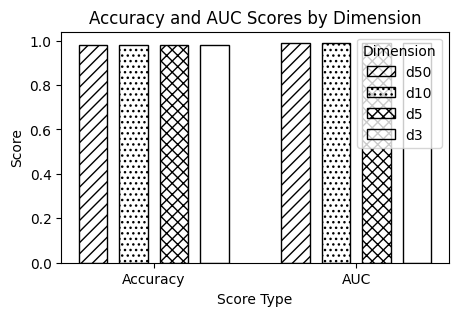

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import roc_curve, auc

# Data
score_type = ['Accuracy', 'AUC']
d50 = [0.98, 0.99]
d10 = [0.98, 0.99]
d5 = [0.98, 0.99]
d3 = [0.98, 0.99]

# Plot
plt.figure(figsize=(5, 3))

# Extract ACC and AUC values for each dimension
d50_values = [d50[0], d50[1]]
d10_values = [d10[0], d10[1]]
d5_values = [d5[0], d5[1]]
d3_values = [d3[0], d3[1]]

# Set bar width
bar_width = 0.14

# Plot ACC values
plt.bar(np.arange(len(score_type)) - 0.3, d50_values, width=bar_width, label='d50', fill = False, hatch='///', edgecolor='black')
plt.bar(np.arange(len(score_type)) - 0.1, d10_values, width=bar_width, label='d10', fill = False, hatch='...', edgecolor='black')
plt.bar(np.arange(len(score_type)) + 0.1, d5_values, width=bar_width, label='d5', fill = False, hatch='xxx', edgecolor='black')
plt.bar(np.arange(len(score_type)) + 0.3, d3_values, width=bar_width, label='d3', fill = False, hatch='', edgecolor='black')

# Add labels and title
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.title('Accuracy and AUC Scores by Dimension')
plt.xticks(np.arange(len(score_type)), score_type)
plt.legend(title='Dimension')

# Show plot
plt.savefig(os.path.join(acc_plt,"svm_loo_bulkATAC_d50") + "_acc_auc.pdf", format="pdf")
plt.show()

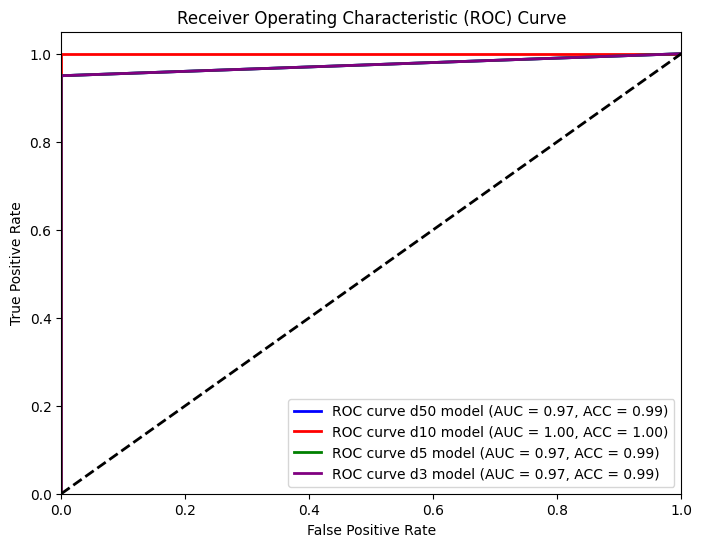

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import roc_curve, auc
d50_df = pd.read_csv(os.path.join(loo_res+"_d50","similarity_score_mm10.csv"))
d10_df = pd.read_csv(os.path.join(loo_res+"_d10","similarity_score_mm10.csv"))
d5_df = pd.read_csv(os.path.join(loo_res+"_d5","similarity_score_mm10.csv"))
d3_df = pd.read_csv(os.path.join(loo_res+"_d3","similarity_score_mm10.csv"))

# d50_df = pd.read_csv(os.path.join(bulk_res+"_d50","similarity_score_mm10.csv"))
# d10_df = pd.read_csv(os.path.join(bulk_res+"_d10","similarity_score_mm10.csv"))
# d5_df = pd.read_csv(os.path.join(bulk_res+"_d5","similarity_score_mm10.csv"))
# d3_df = pd.read_csv(os.path.join(bulk_res+"_d3","similarity_score_mm10.csv"))

def get_pred_labels (df):
    # Convert 'dist' column to numeric
    df['dist'] = pd.to_numeric(df['dist'])

    # Group by 'name' column and select the row with minimum 'dist' value in each group
    predicted_labels_df = df.loc[df.groupby('name')['dist'].idxmin()]

    # Drop unnecessary columns
    predicted_labels_df = predicted_labels_df.drop(columns=['name', 'dist'])
    
    # Map labels to numerical values
    label_mapping = {'Non_Renin': 0, 'Renin': 1}
    predicted_labels_df['true_label'] = predicted_labels_df['file_label'].map(label_mapping)
    predicted_labels_df['predicted_label'] = predicted_labels_df['classes'].map(label_mapping)
    # print(predicted_labels_df)

    # Print the resulting DataFrame
    return predicted_labels_df['predicted_label'].tolist(), predicted_labels_df['true_label'].tolist()


# Define sets of predicted labels and true labels
predicted_labels_d50, true_labels_d50 = get_pred_labels (d50_df)
predicted_labels_d10, true_labels_d10 = get_pred_labels (d10_df)
predicted_labels_d5, true_labels_d5 = get_pred_labels (d5_df)
predicted_labels_d3, true_labels_d3 = get_pred_labels (d3_df)

# # Compute ROC curve and ROC area for each class
fpr_d50, tpr_d50, _ = roc_curve(true_labels_d50, predicted_labels_d50)
roc_auc_d50 = auc(fpr_d50, tpr_d50)
acc_d50 = accuracy_score(predicted_labels_d50,  true_labels_d50)

fpr_d10, tpr_d10, _ = roc_curve(true_labels_d10, predicted_labels_d10)
roc_auc_d10 = auc(fpr_d10, tpr_d10)
acc_d10 = accuracy_score(predicted_labels_d10,  true_labels_d10)

fpr_d5, tpr_d5, _ = roc_curve(true_labels_d5, predicted_labels_d5)
roc_auc_d5 = auc(fpr_d5, tpr_d5)
acc_d5 = accuracy_score(predicted_labels_d5,  true_labels_d5)

fpr_d3, tpr_d3, _ = roc_curve(true_labels_d3, predicted_labels_d3)
roc_auc_d3 = auc(fpr_d3, tpr_d3)
acc_d3 = accuracy_score(predicted_labels_d3,  true_labels_d3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_d50, tpr_d50, color='blue', lw=2, label=f'ROC curve d50 model (AUC = {roc_auc_d50:.2f}, ACC = {acc_d50:.2f})')
plt.plot(fpr_d10, tpr_d10, color='red', lw=2, label=f'ROC curve d10 model (AUC = {roc_auc_d10:.2f}, ACC = {acc_d10:.2f})')
plt.plot(fpr_d5, tpr_d5, color='green', lw=2, label=f'ROC curve d5 model (AUC = {roc_auc_d5:.2f}, ACC = {acc_d5:.2f})')
plt.plot(fpr_d3, tpr_d3, color='purple', lw=2, label=f'ROC curve d3 model (AUC = {roc_auc_d3:.2f}, ACC = {acc_d3:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# # Data
# score_type = ['Accuracy', 'AUC']
# d50 = [acc_d50, roc_auc_d50]
# d10 = [acc_d10, roc_auc_d10]
# d5 = [acc_d5, roc_auc_d5]
# d3 = [acc_d3, roc_auc_d3]

# # Plot
# plt.figure(figsize=(5, 3))

# # Extract ACC and AUC values for each dimension
# d50_values = [d50[0], d50[1]]
# d10_values = [d10[0], d10[1]]
# d5_values = [d5[0], d5[1]]
# d3_values = [d3[0], d3[1]]

# # Set bar width
# bar_width = 0.14

# # Plot ACC values
# plt.bar(np.arange(len(score_type)) - 0.3, d50_values, width=bar_width, label='d50', fill = False, hatch='///', edgecolor='black')
# plt.bar(np.arange(len(score_type)) - 0.1, d10_values, width=bar_width, label='d10', fill = False, hatch='...', edgecolor='black')
# plt.bar(np.arange(len(score_type)) + 0.1, d5_values, width=bar_width, label='d5', fill = False, hatch='xxx', edgecolor='black')
# plt.bar(np.arange(len(score_type)) + 0.3, d3_values, width=bar_width, label='d3', fill = False, hatch='', edgecolor='black')

# # Add labels and title
# plt.xlabel('Score Type')
# plt.ylabel('Score')
# plt.title('Accuracy and AUC Scores by Dimension')
# plt.xticks(np.arange(len(score_type)), score_type)
# plt.legend(title='Dimension')

# # Show plot
# # plt.savefig(os.path.join(acc_plt,"loo_bulkATAC_d50") + "_acc_auc.pdf", format="pdf")
# plt.show()

# 5b. Evaluating with bulk ATAC-seq data
## Data source
Same data set used in differential accessibility analysis

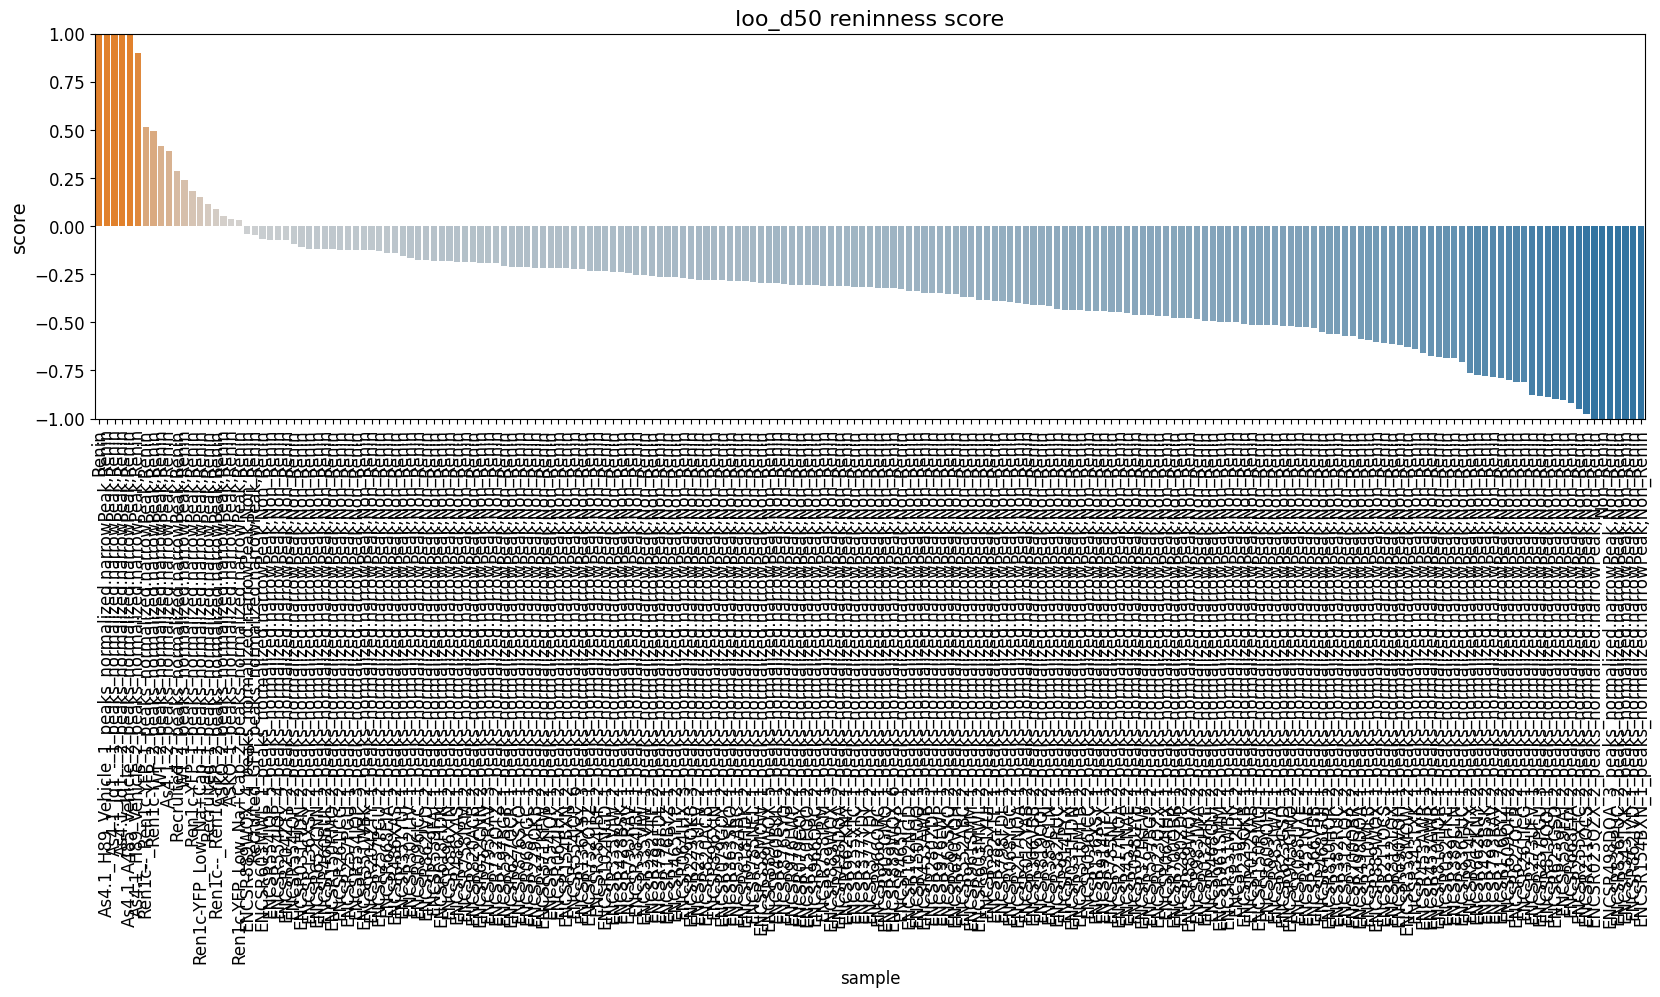

In [23]:
loo_score = pd.read_csv("/scratch/bx2ur/code/reninness_score/outputs/testloo_d50/reninness_score_mm10.csv")
plot_reninness_score(loo_score, "loo_d50", True)

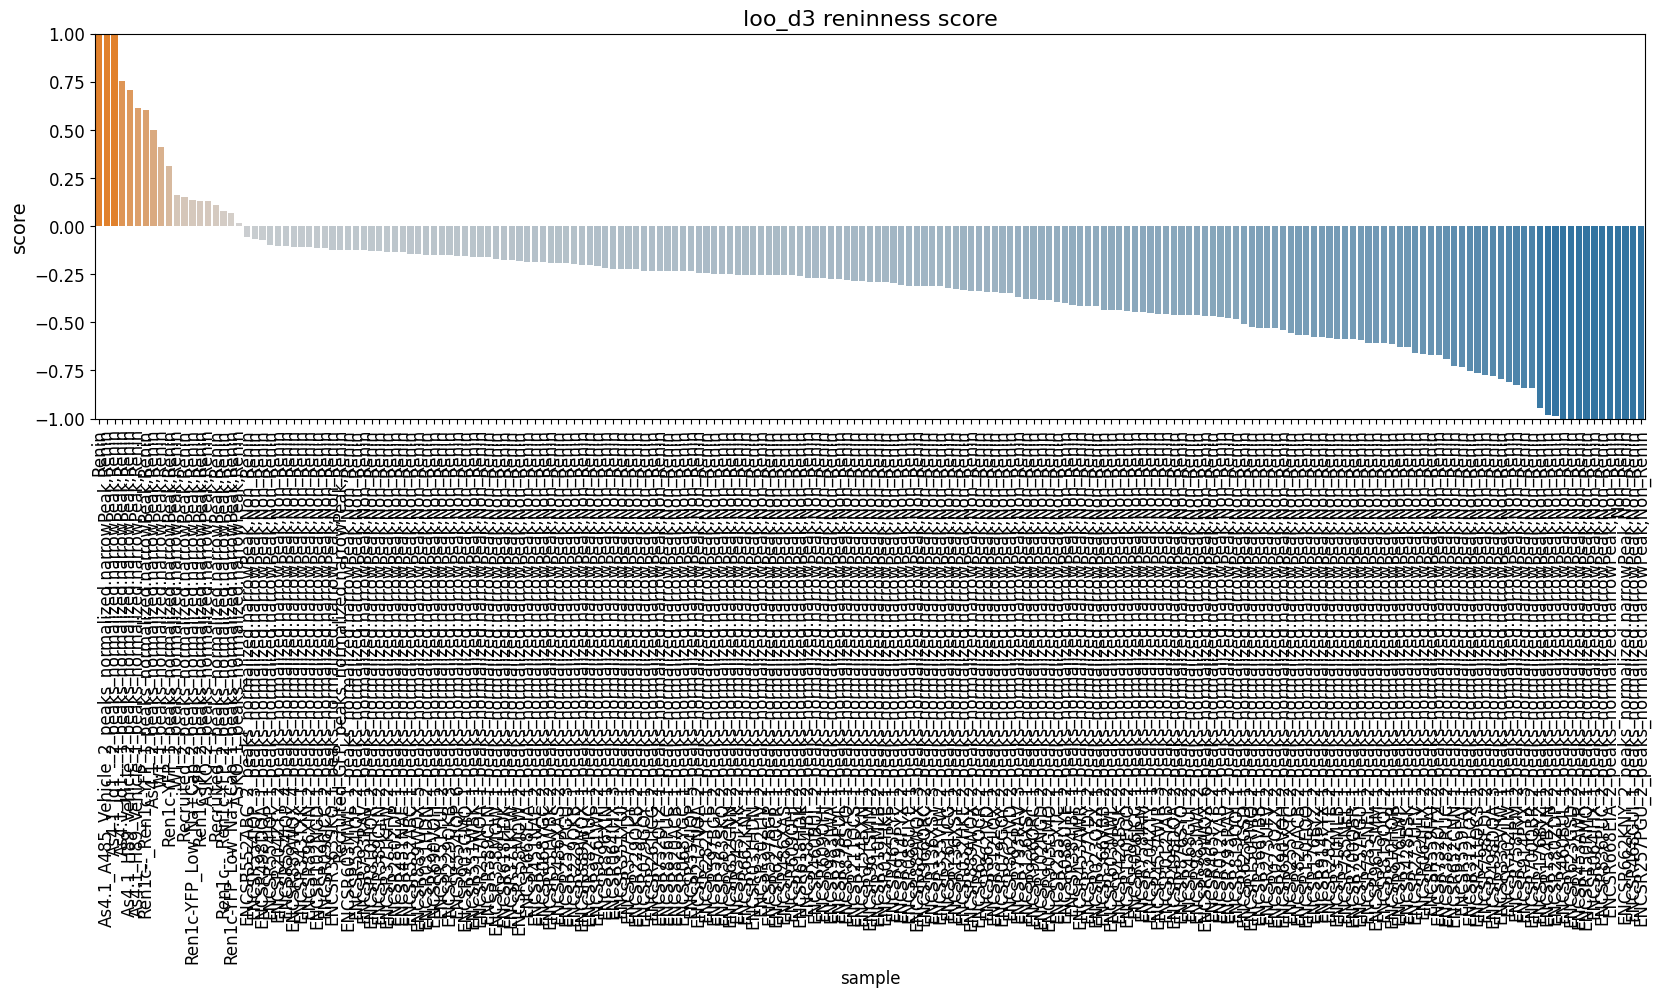

In [9]:
loo_score = pd.read_csv("/scratch/bx2ur/code/reninness_score/outputs/testloo_d3/reninness_score_mm10.csv")
plot_reninness_score(loo_score, "loo_d3", True)

In [37]:
bulk_scores = pd.read_csv(os.path.join(bulk_res,"reninness_score_mm10.csv"))
bulk_scores

name file_label   score
0               WT_1_peaks_normalized.narrowPeak,Renin      Renin  0.0651
1               WT_2_peaks_normalized.narrowPeak,Renin      Renin  0.0804
2        Ren1c-YFP_1_peaks_normalized.narrowPeak,Renin      Renin  0.0651
3        Ren1c-YFP_2_peaks_normalized.narrowPeak,Renin      Renin  0.0807
4        Recruited_1_peaks_normalized.narrowPeak,Renin      Renin  0.0732
..                                                 ...        ...     ...
129  Female_Brownfat_Rep1_peaks_normalized.narrowPe...  Non_Renin -0.0574
130  Female_Mesentericfat_Rep1_peaks_normalized.nar...  Non_Renin -0.1099
131  Male_Adrenalgland_Rep1_peaks_normalized.narrow...  Non_Renin -0.0497
132                                          Non_Renin  Non_Renin -1.0000
133                                              Renin      Renin  1.0000

[134 rows x 3 columns]

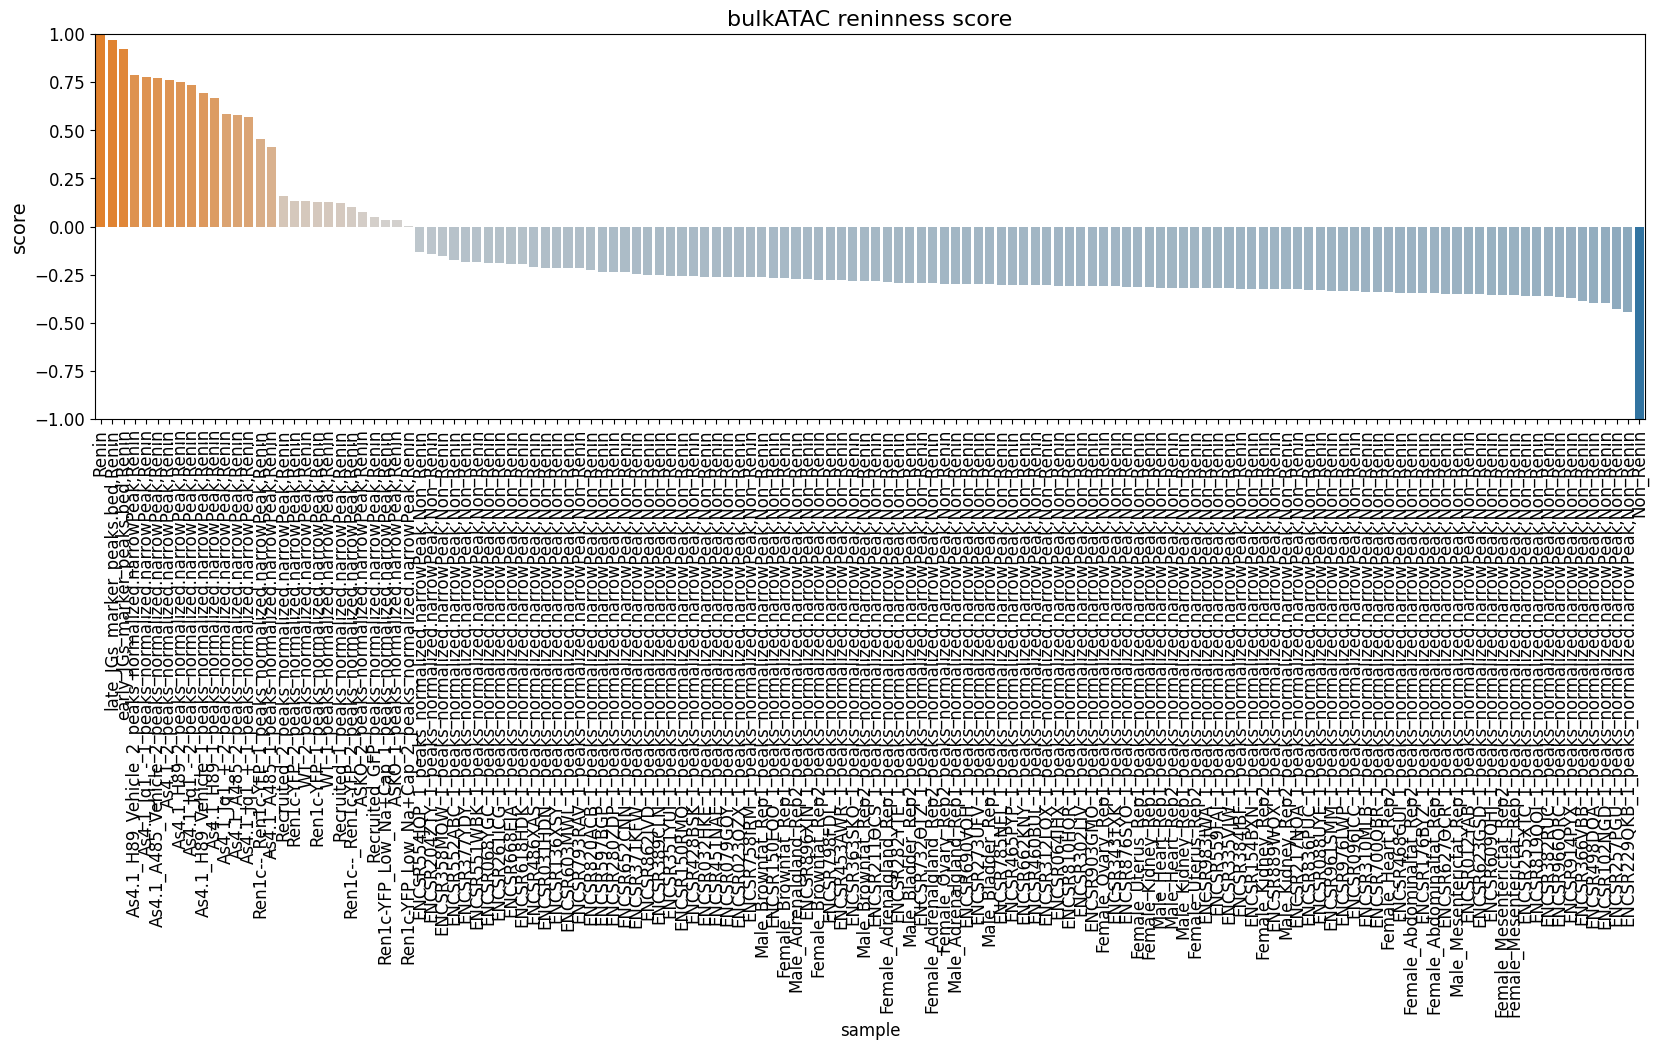

In [50]:
#d50
plot_reninness_score(bulk_scores, "bulkATAC", True)

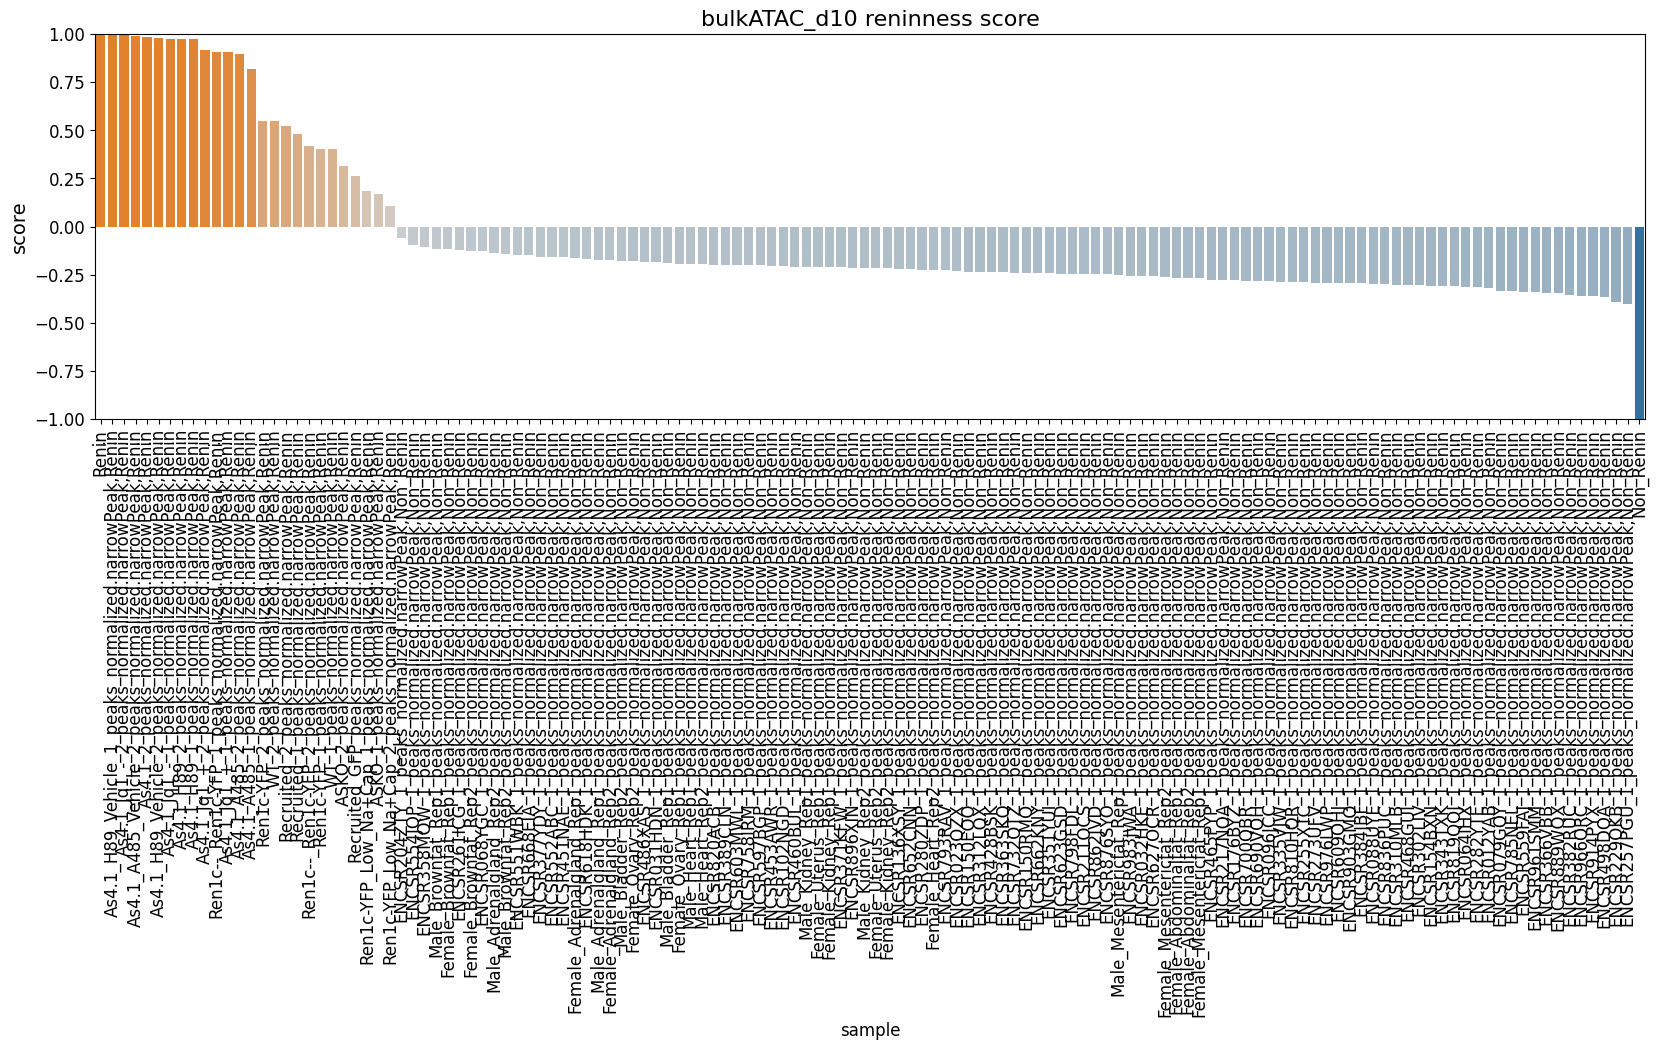

In [91]:
#d10
plot_reninness_score(bulk_scores, "bulkATAC_d10", True)

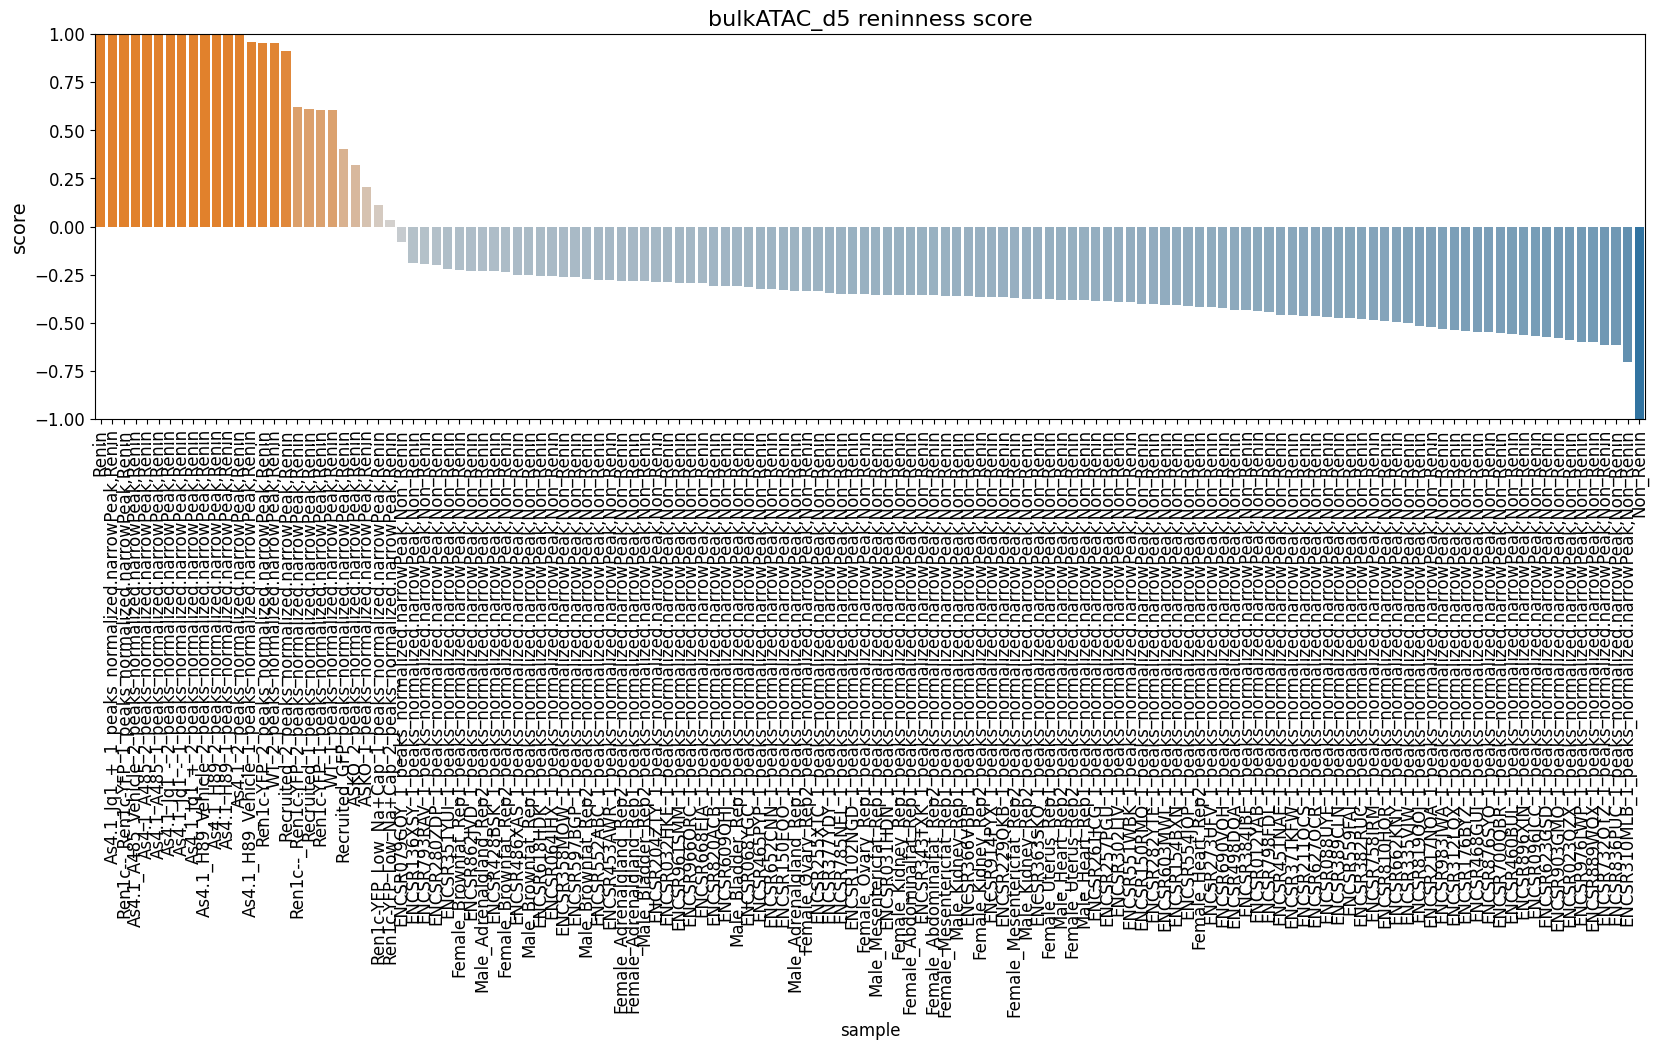

In [11]:
#d5
plot_reninness_score(bulk_scores, "bulkATAC_d5", True)

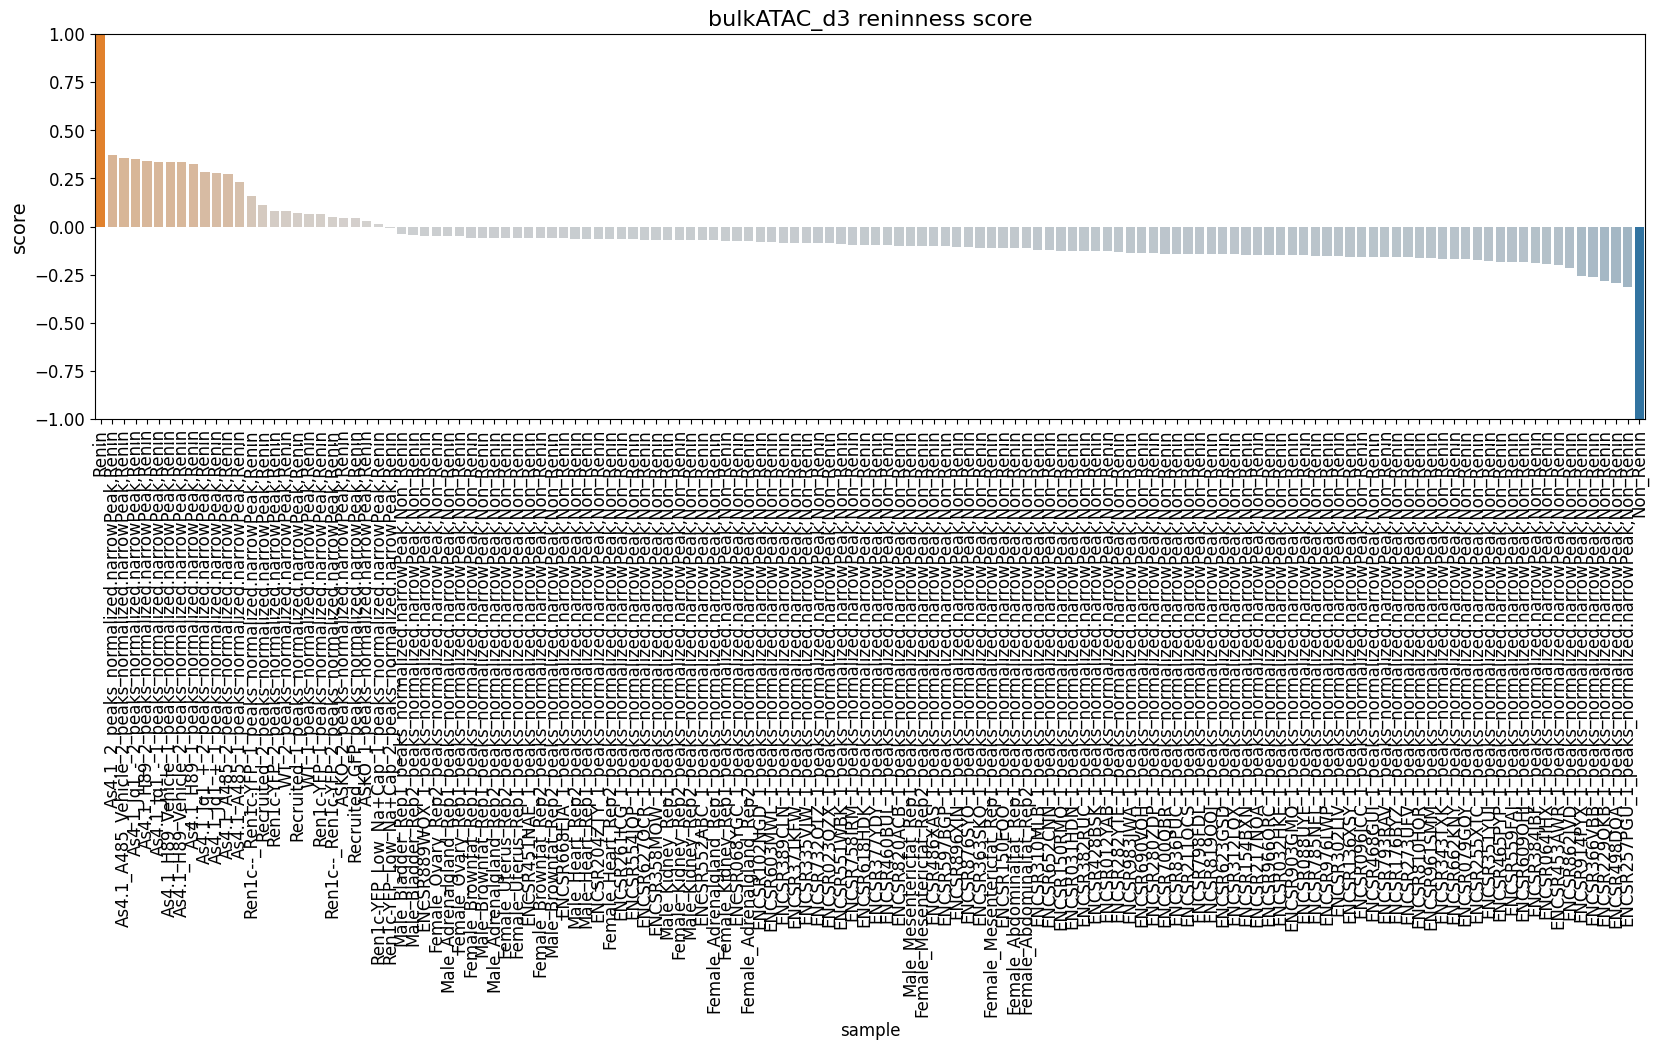

In [38]:
#d3
plot_reninness_score(bulk_scores, "bulkATAC_d3", True)

In [19]:
bulk_X, bulk_y = get_embedding_matrix(
    os.path.join(bulk_res+"_d3", doc_embed), 
    os.path.join(bulk_res+"_d3", word_embed),
    2
)


In [50]:
np.savetxt('/scratch/bx2ur/bulkATAC_embedding.txt', bulk_X)
np.savetxt('/scratch/bx2ur/bulkATAC_labels.txt', bulk_y, fmt='%s')

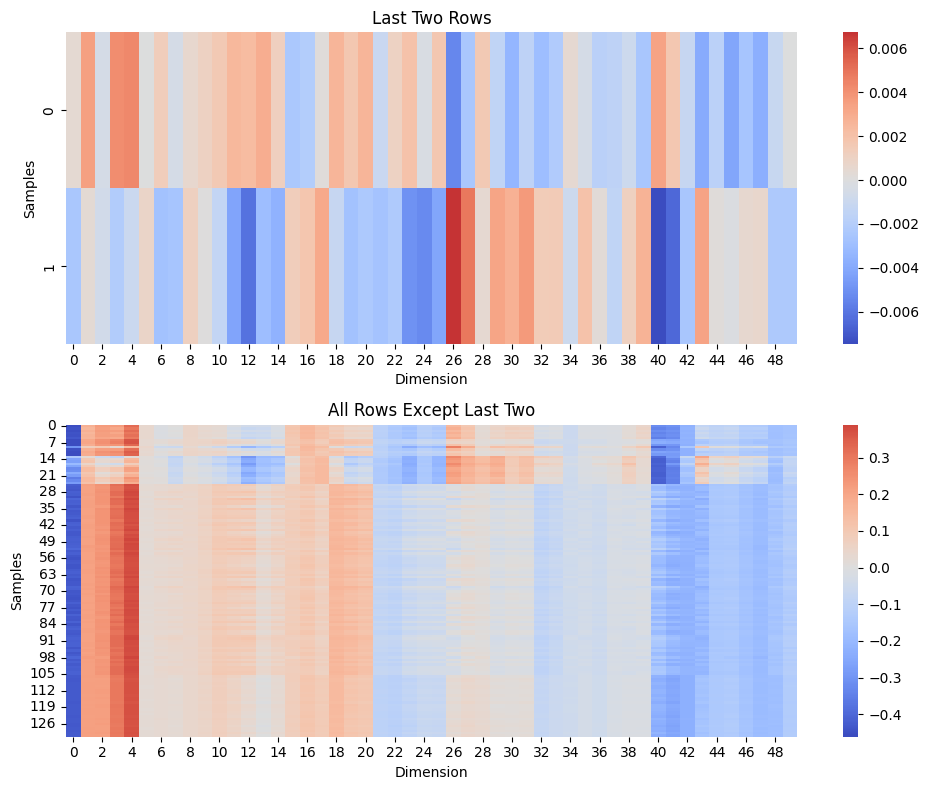

In [47]:
#d50
plot_embed_heatmap(bulk_X,os.path.join(heatmap_plt,"bulkATAC_d50"))

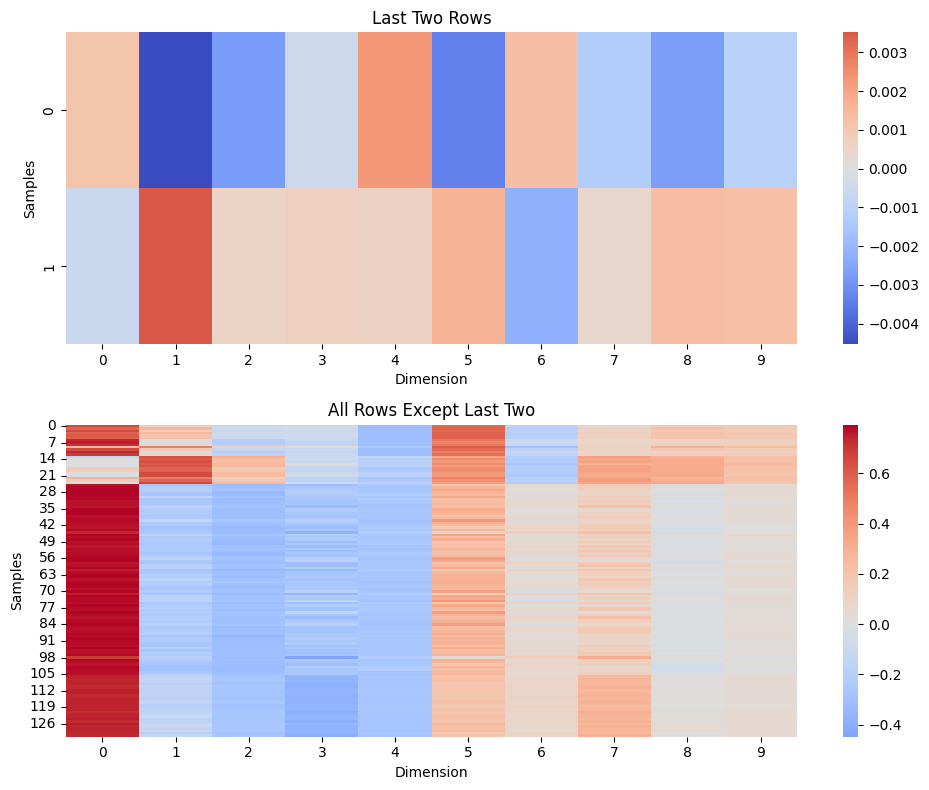

In [16]:
#d10
plot_embed_heatmap(bulk_X, os.path.join(heatmap_plt,"bulkATAC_d10"))

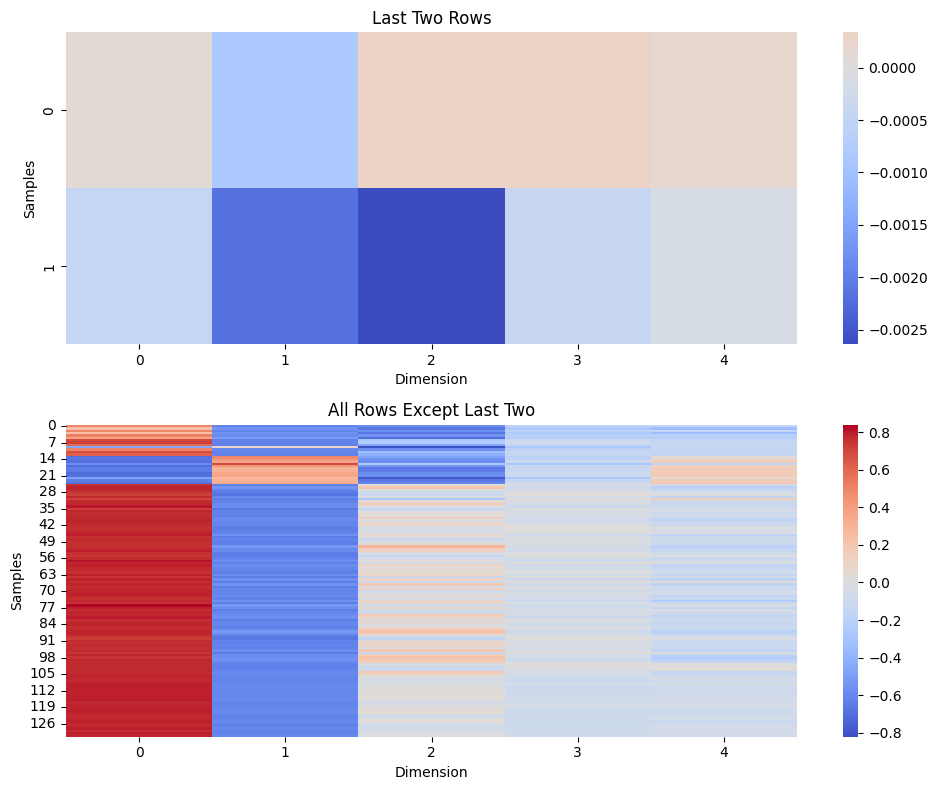

In [18]:
#d5
plot_embed_heatmap(bulk_X, os.path.join(heatmap_plt,"bulkATAC_d5"))

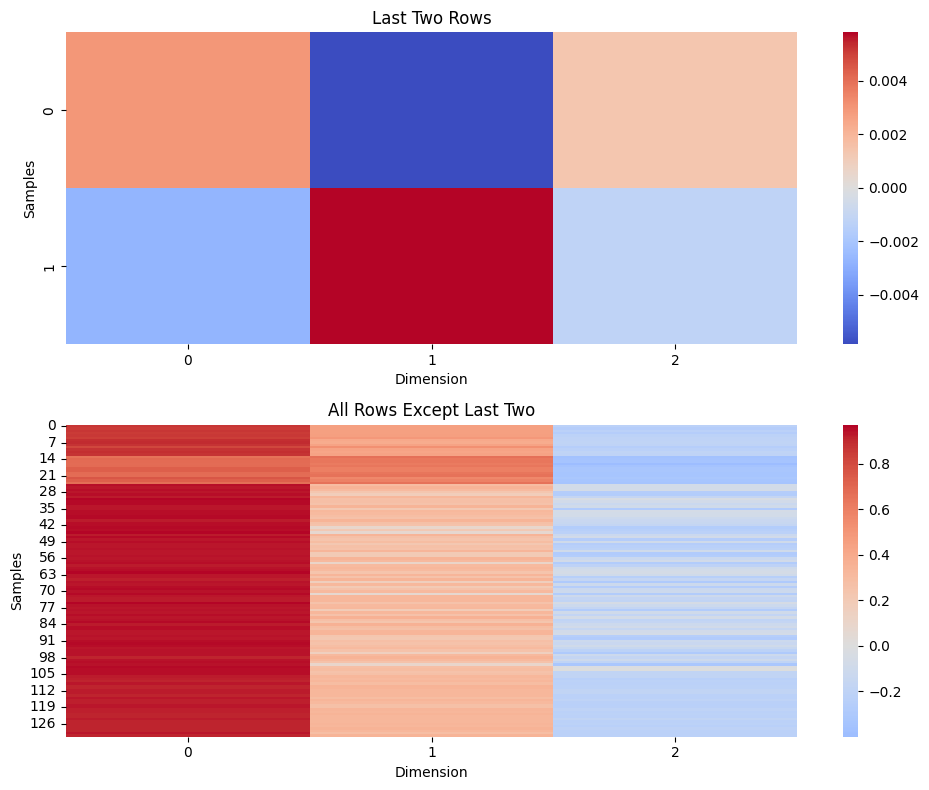

In [20]:
#d3
plot_embed_heatmap(bulk_X, os.path.join(heatmap_plt,"bulkATAC_d3"))

/tmp/ipykernel_989642/1878899248.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


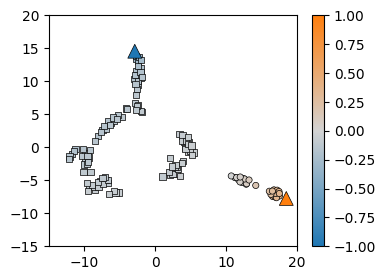

In [62]:
#d5
# model_type = "tsne"
# nn = 15
# metric ='cosine'

# model, data_plot_bulk = reduce_embed_dim(
#     np.array(bulk_X), 
#     bulk_y, 
#     bulk_scores, 
#     model_type = model_type, 
#     n_neighbours = nn, 
#     metric = metric
# )

plot_embed(data_plot_bulk, os.path.join(tsne_plt,"bulkATAC_d3"), train=True)

# 5c. Evaluating with scATAC-seq data

## Data source

Martini AG, Smith JP, Medrano S, Finer G, Sheffield NC, Sequeira-Lopez MLS, Gomez RA. Renin Cell Development: Insights From Chromatin Accessibility and Single-Cell Transcriptomics. Circ Res. 2023 Aug 4;133(4):369-371. doi: 10.1161/CIRCRESAHA.123.322827. Epub 2023 Jul 3. PMID: 37395102; PMCID: PMC10529662.

```
# download data from  GEO: GSE218570
wget -O GSE218570_raw.tar 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE218570&format=file'
```

## pseudo-bulk ATAC-seq data of pre-defined cell type clusters

In [44]:
pseudobulk_scores = pd.read_csv(os.path.join(cluster_res,"reninness_score_mm10.csv"))

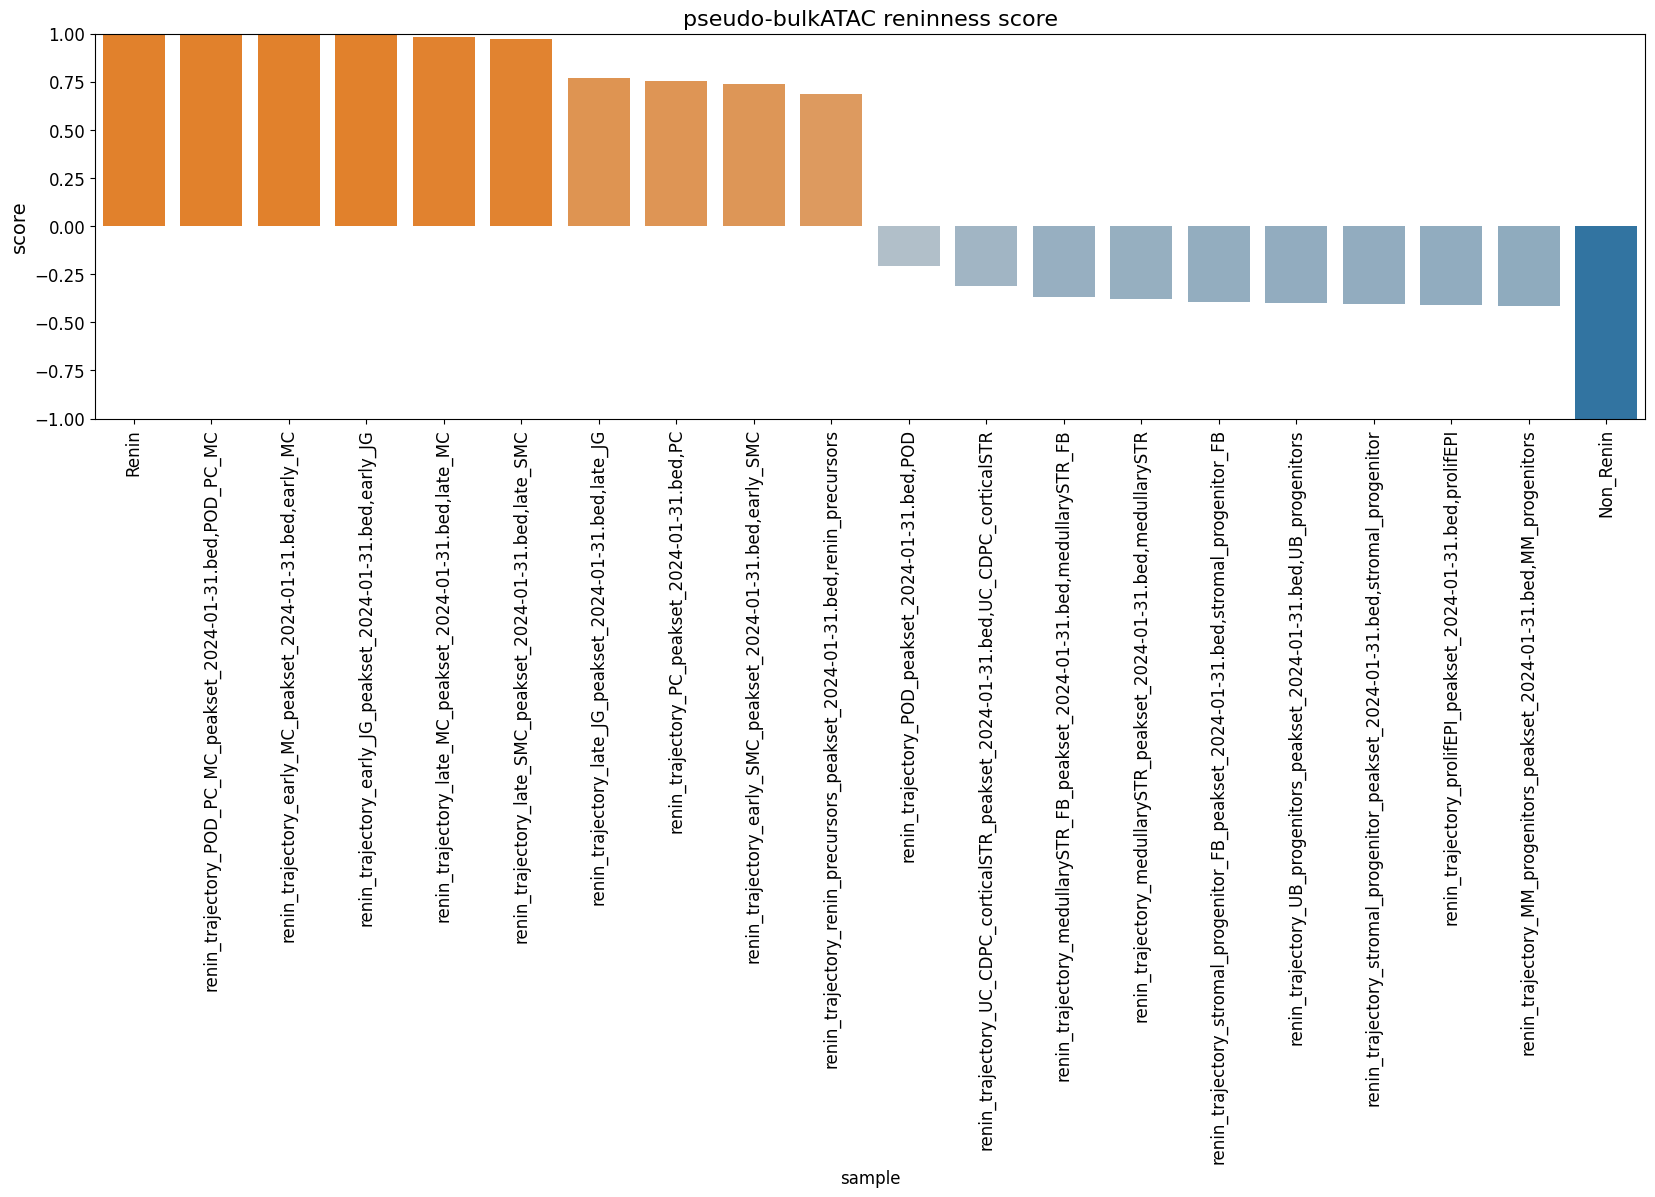

In [154]:
#d50
plot_reninness_score(pseudobulk_scores, "pseudo-bulkATAC", True)

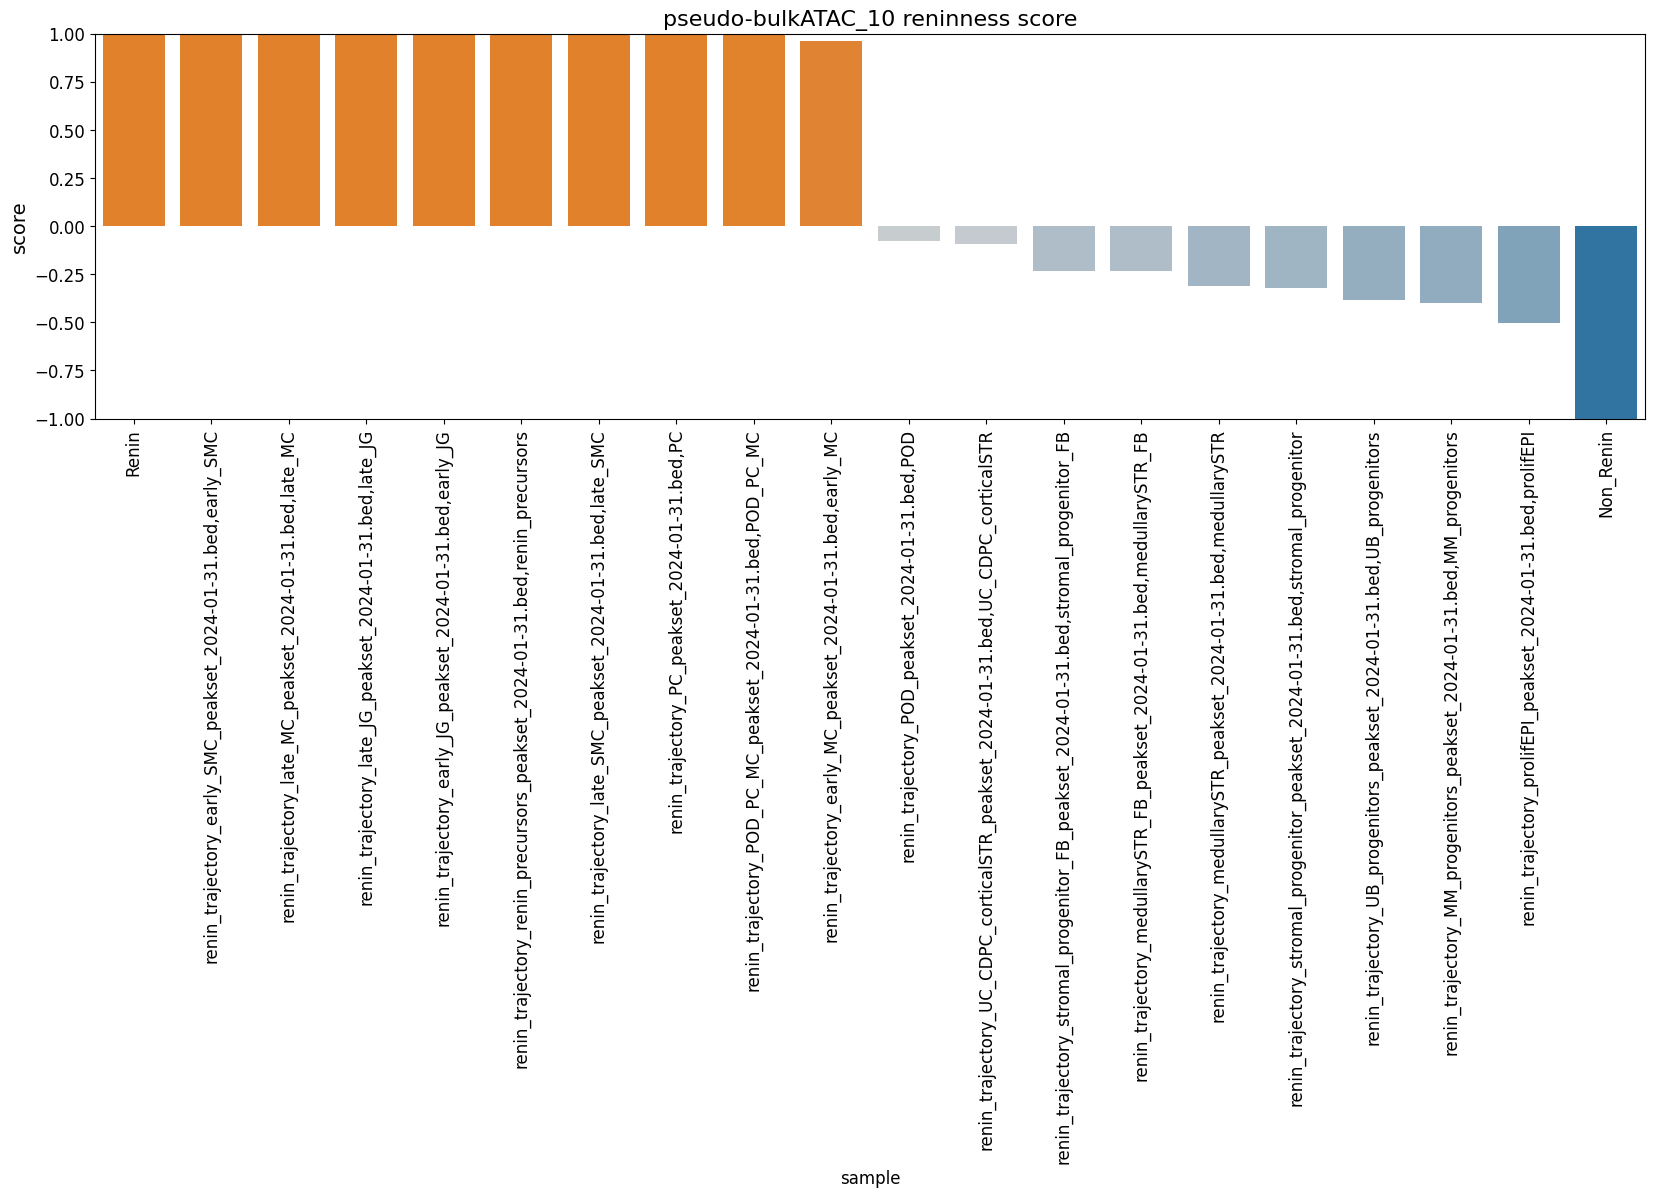

In [100]:
#d10
plot_reninness_score(pseudobulk_scores, "pseudo-bulkATAC_10", True)

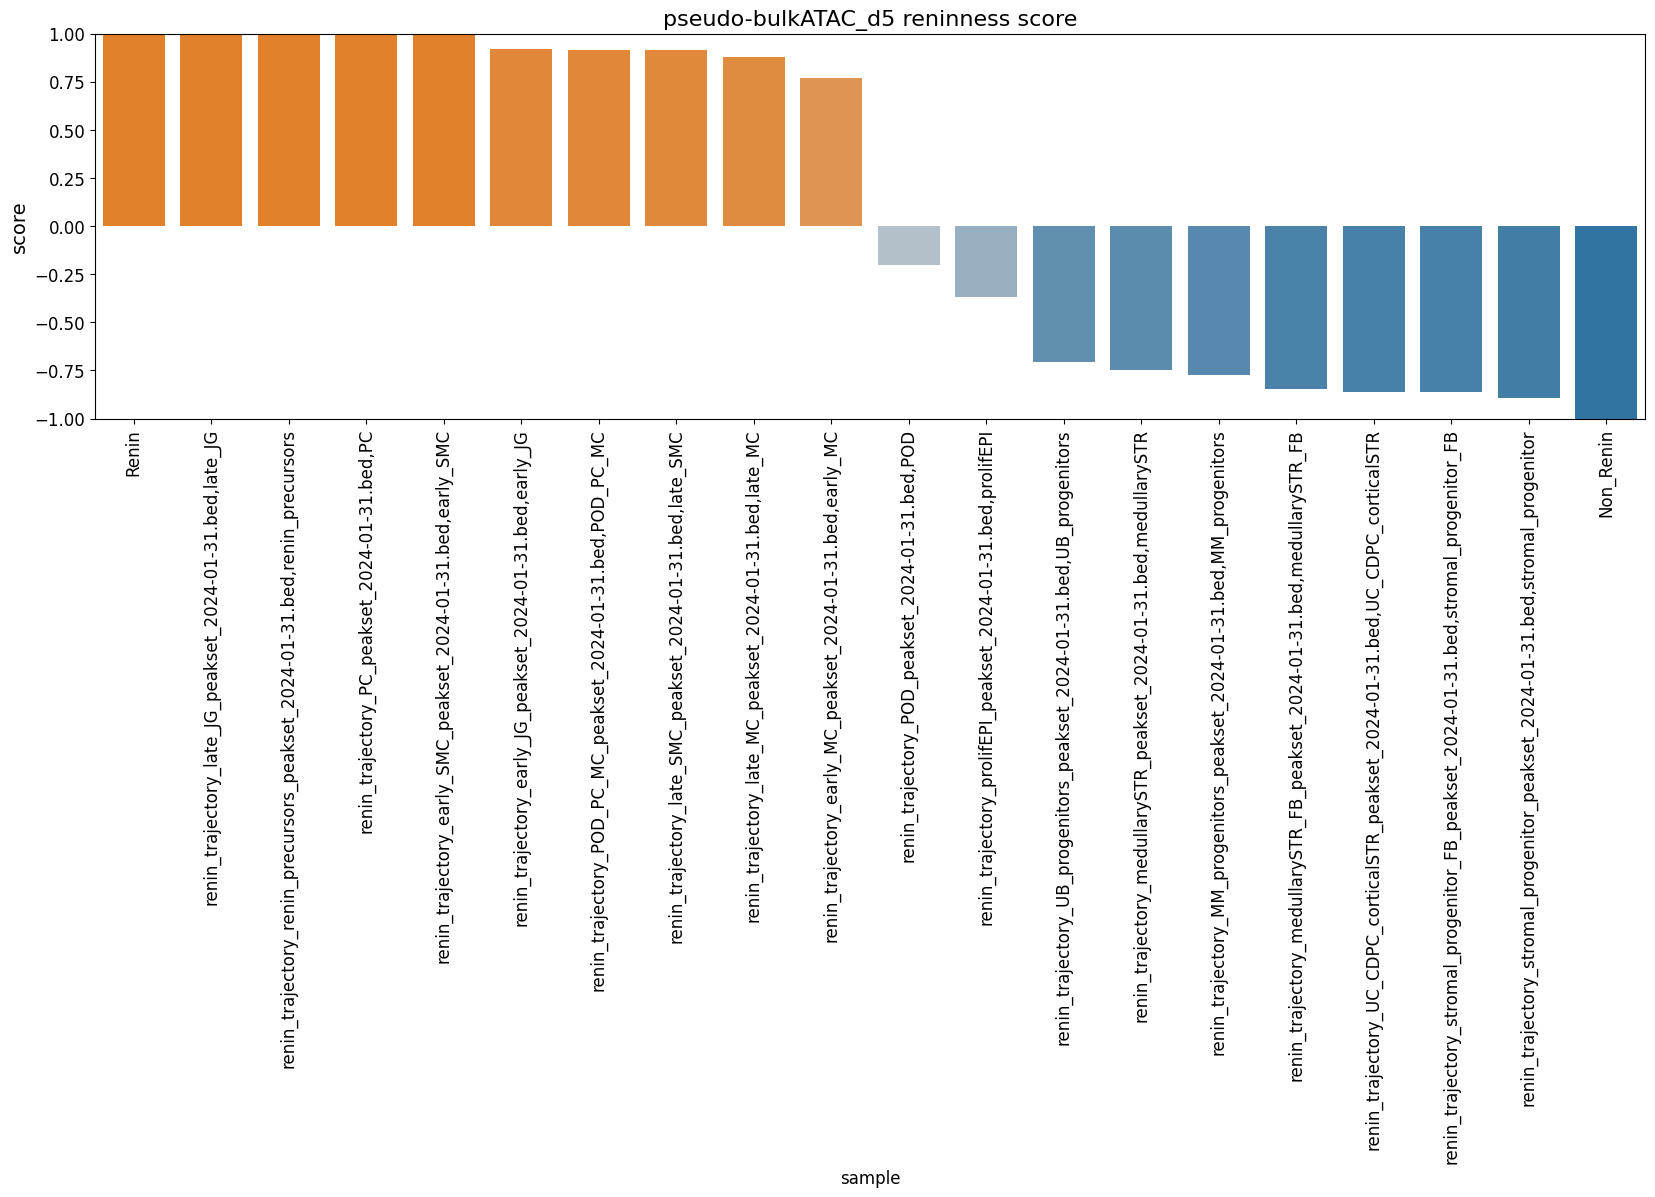

In [15]:
#d5
plot_reninness_score(pseudobulk_scores, "pseudo-bulkATAC_d5", True)

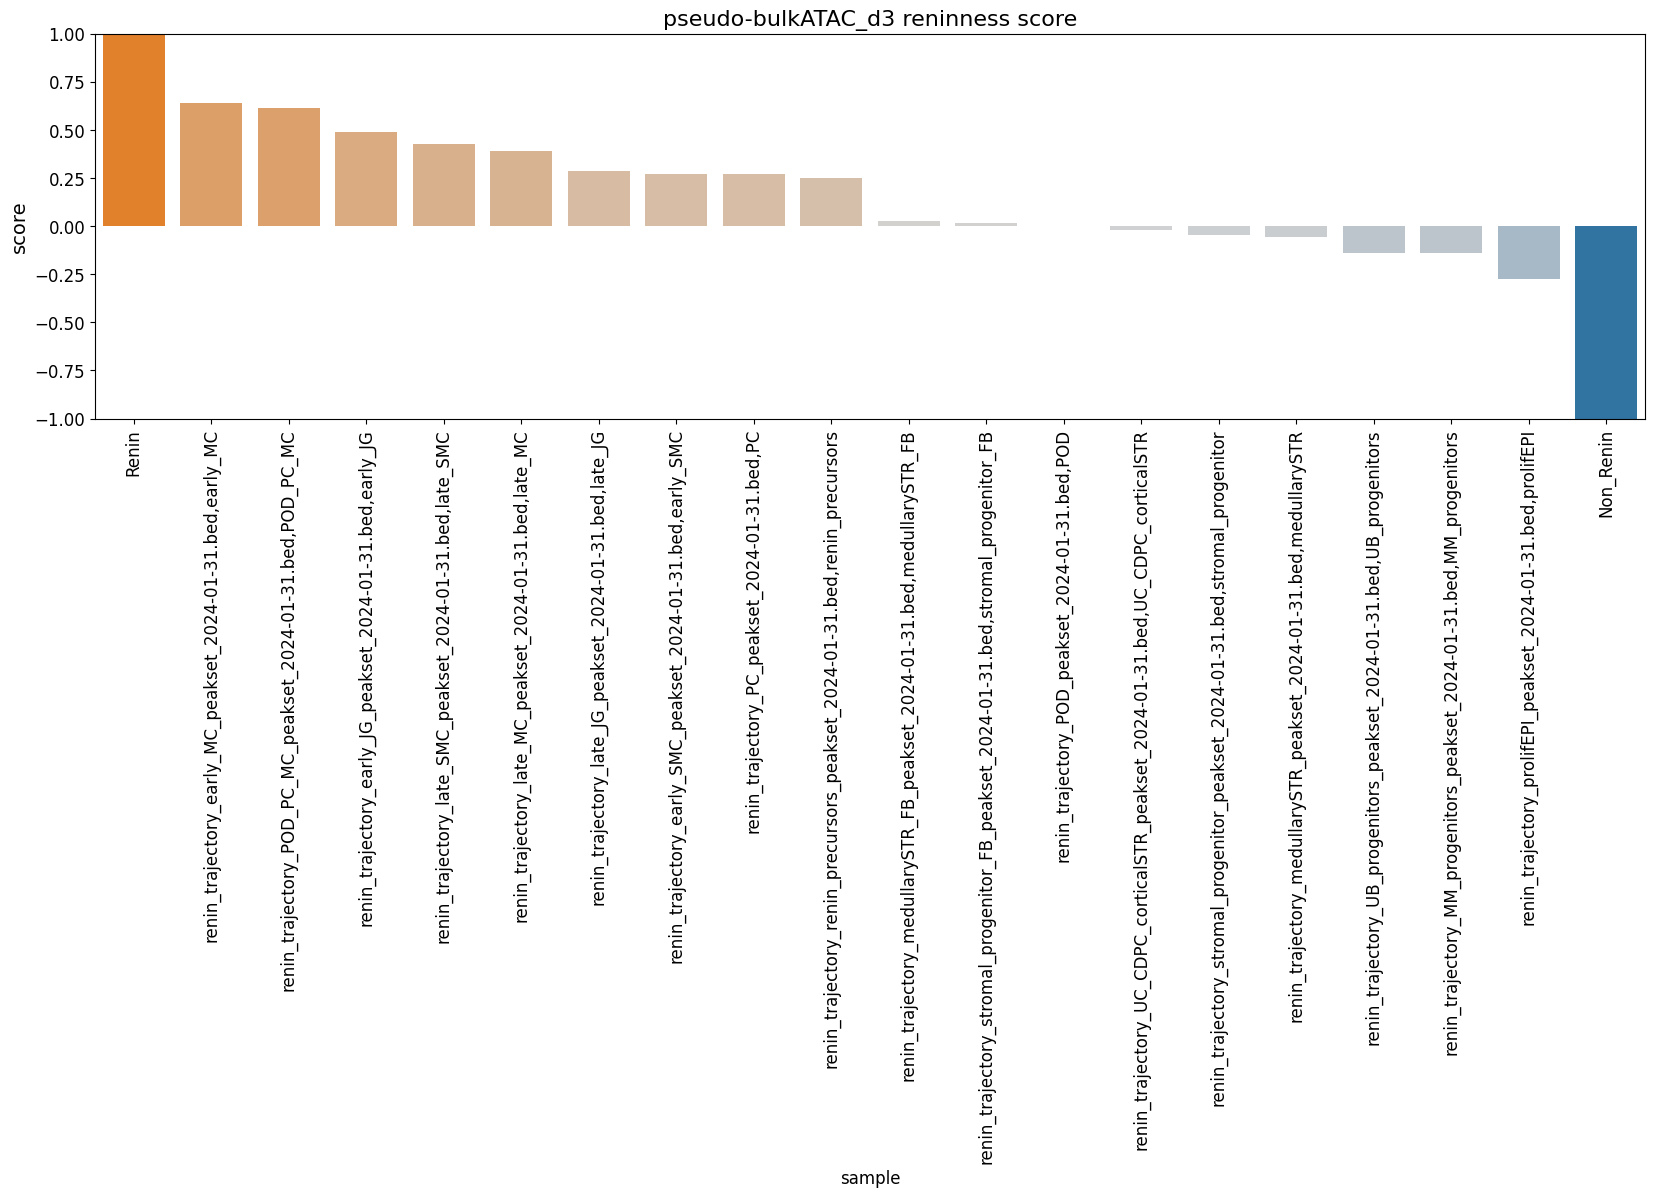

In [45]:
#d3
plot_reninness_score(pseudobulk_scores, "pseudo-bulkATAC_d3", True)

In [46]:
cluster_X, cluster_y = get_embedding_matrix(
    os.path.join(cluster_res, doc_embed), 
    os.path.join(bulk_res, word_embed),
    2
)

/tmp/ipykernel_989642/1878899248.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


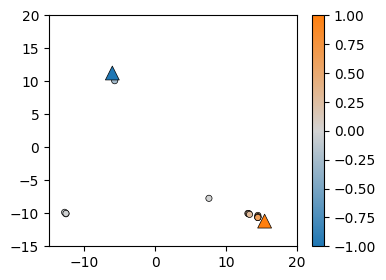

In [63]:
# model, data_plot_cluster = reduce_embed_dim(
#     np.array(cluster_X), 
#     cluster_y, 
#     pseudobulk_scores, 
#     model_type = model_type, 
#     n_neighbours = nn, 
#     metric = metric, 
#     model = model
# )
plot_embed(data_plot_cluster, os.path.join(tsne_plt,"pseudo-bulkATAC_d3"), train=True)


## pseudo-bulk ATAC-seq data of single cell peak sets

In [7]:
sc_scores = pd.read_csv(os.path.join(sc_res,"reninness_score_mm10.csv"))

In [8]:
# define pos and neg labels based on results from scATAC-seq pre-defined cell type clusters
renin_pos = [
    "early_JG", "late_JG",
    "early_MC",  "late_MC", 
    "early_SMC", "late_SMC",  
    "POD_PC_MC", "PC", 
    "renin_precursors"
]
renin_neg = [
    "POD",
    "UC_CDPC_corticalSTR", 
    "medullarySTR_FB", 
    "medullarySTR", 
    "UB_progenitors", 
    "stromal_progenitor", 
    "prolifEPI", 
    "MM_progenitors", 
    "stromal_progenitor_FB"
]

# Filter score_df for rows where 'file_label' is not in renin_neg
score_ren_pos_df = sc_scores[~sc_scores['file_label'].isin(renin_neg)]

# Filter score_df for rows where 'file_label' is not in renin_pos
score_ren_neg_df = sc_scores[~sc_scores['file_label'].isin(renin_pos)]

In [9]:
len(score_ren_pos_df)

1586

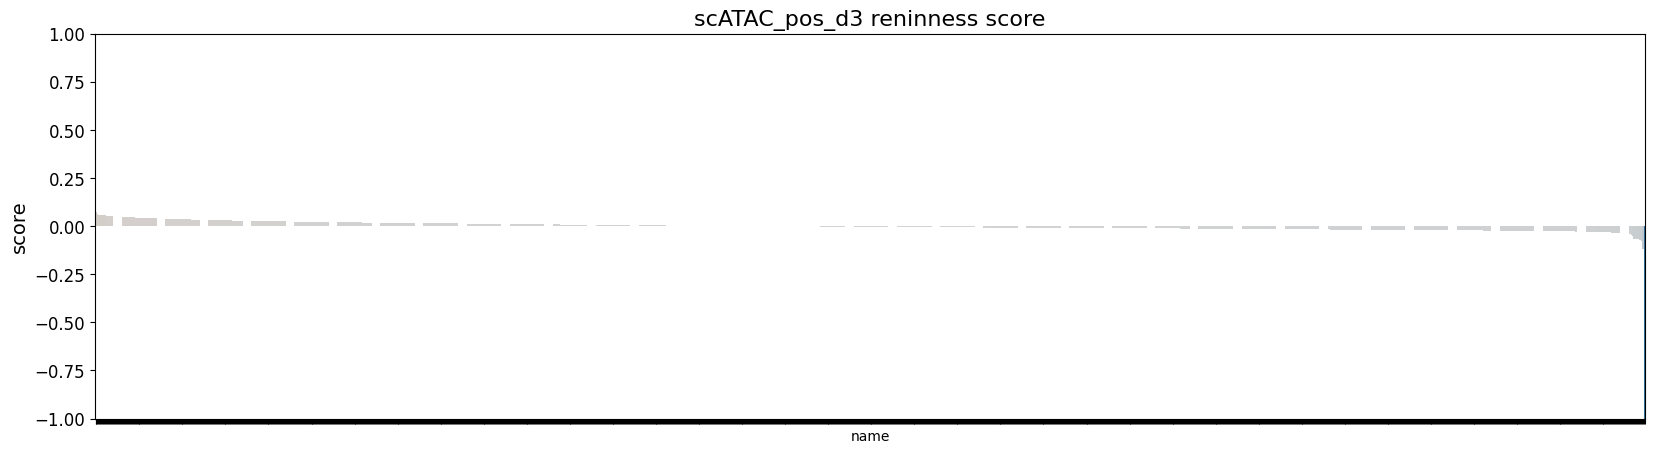

In [12]:
# plot cells in the pos cell types
plot_reninness_score(score_ren_pos_df, "scATAC_pos_d3", False)

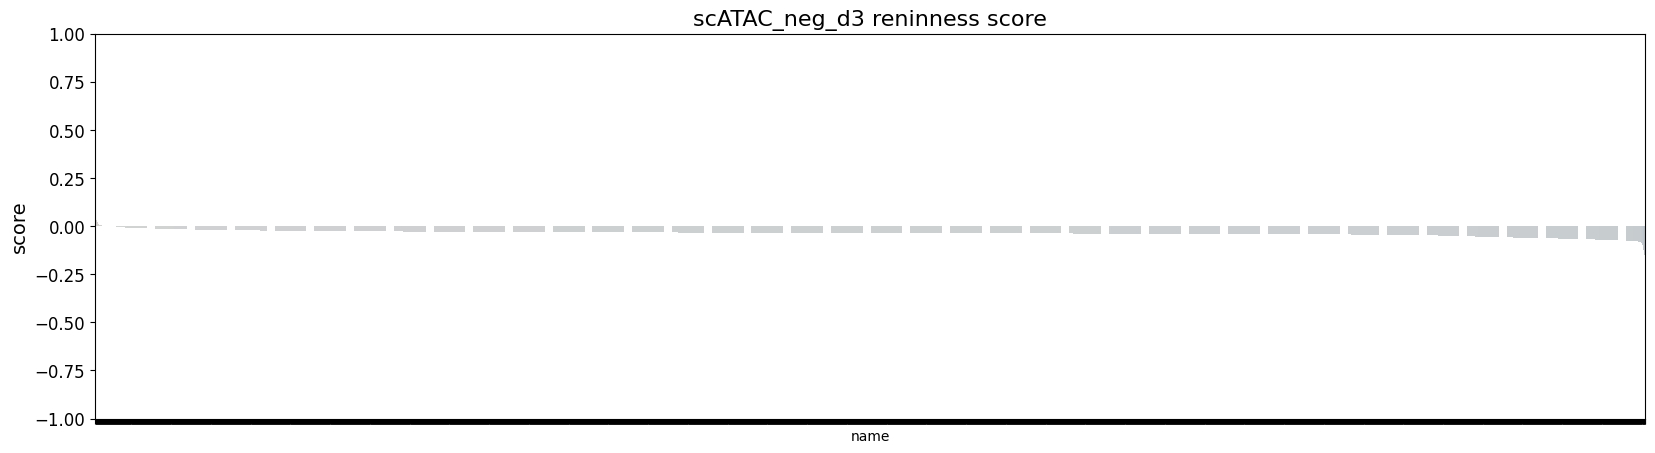

In [13]:
# plot cells in the pos cell types
plot_reninness_score(score_ren_neg_df, "scATAC_neg_d3", False)

In [ ]:
# plot each cell type separately

for t in renin_pos:
    plot_reninness_score(score_ren_pos_df[score_ren_pos_df['file_label'] == t], "scATAC_"+t, False)

for t in renin_neg:
    plot_reninness_score(score_ren_neg_df[score_ren_neg_df['file_label'] == t], "scATAC_"+t, False)



In [52]:
sc_X, sc_y = get_embedding_matrix(
    os.path.join(sc_res, doc_embed), 
    os.path.join(bulk_res, word_embed),
    2
)

In [37]:
np.savetxt('/scratch/bx2ur/scATAC_embedding.txt', sc_X)
np.savetxt('/scratch/bx2ur/scATAC_labels.txt', np.array(sc_y), fmt='%s')

/tmp/ipykernel_989642/1878899248.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


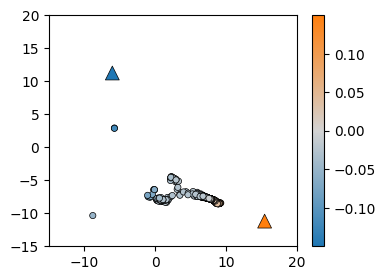

In [64]:
# plot pos
# idx = [i for i, item in enumerate(sc_y) if item in renin_neg]

# sc_y_pos = [item for i, item in enumerate(sc_y) if i not in idx]
# sc_X_pos = [item for i, item in enumerate(sc_X) if i not in idx]
# sc_scores_pos = sc_scores.drop(idx).reset_index(drop=True)

# model, data_plot_sc_pos = reduce_embed_dim(
#     np.array(sc_X_pos), 
#     sc_y_pos, 
#     sc_scores_pos, 
#     model_type = model_type,
#     n_neighbours = nn, 
#     metric = metric, 
#     model = model
# )

plot_embed(data_plot_sc_pos, os.path.join(tsne_plt,"scATAC_pos_d3"), train=False)


/tmp/ipykernel_989642/1878899248.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


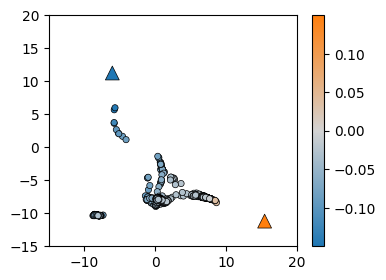

In [65]:
# plot neg
# idx = [i for i, item in enumerate(sc_y) if item in renin_pos]

# sc_y_neg = [item for i, item in enumerate(sc_y) if i not in idx]
# sc_X_neg = [item for i, item in enumerate(sc_X) if i not in idx]
# sc_scores_neg = sc_scores.drop(idx).reset_index(drop=True)

# model, data_plot_sc_neg = reduce_embed_dim(
#     np.array(sc_X_neg), 
#     sc_y_neg, 
#     sc_scores_neg, 
#     model_type = model_type, 
#     n_neighbours = nn, 
#     metric = metric, 
#     model = model
# )

plot_embed(data_plot_sc_neg, os.path.join(tsne_plt,"scATAC_neg_d3"), train=False)

